In [ ]:
import torch, os
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
from PIL import Image
import seaborn as sns

In [ ]:
########################################################################
# The output of torchvision datasets are PILImage images of range [0, 1].

# Apply necessary image transfromations here 

transform = transforms.Compose([#torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                #torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
                                #torchvision.transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])])
print(transform)

Compose(
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)


In [ ]:
train_data_dir = '/content/drive/My Drive/Datasets/3/train' # put path of training dataset
val_data_dir = '/content/drive/My Drive/Datasets/3/val' # put path of validation dataset
test_data_dir = '/content/drive/My Drive/Datasets/3/test' # put path of test dataset

trainset = torchvision.datasets.ImageFolder(root= train_data_dir, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=4)

valset = torchvision.datasets.ImageFolder(root= val_data_dir, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                         shuffle=False, num_workers=4)

testset = torchvision.datasets.ImageFolder(root= test_data_dir, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=4)

In [ ]:
########################################################################
# Define a Convolution Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Copy the neural network from the Neural Networks section before and modify it to
# take 3-channel images (instead of 1-channel images as it was defined).

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [ ]:
# <<<<<<<<<<<<<<<<<<<<< EDIT THE MODEL DEFINITION >>>>>>>>>>>>>>>>>>>>>>>>>>
# Try experimenting by changing the following:
# 1. number of feature maps in conv layer
# 2. Number of conv layers
# 3. Kernel size
# etc etc.,
   

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5)
        self.fc3 = nn.Linear(in_features=512, out_features=33)      # change out_features according to number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = self.fc3(x)
        return x


In [ ]:
################### DO NOT EDIT THE BELOW CODE!!! #######################

#net = ResNet()
net = Net()

# transfer the model to GPU
if torch.cuda.is_available():
    net = net.cuda()

In [ ]:
net.load_state_dict(torch.load('/content/drive/My Drive/Datasets/Final_Model.pth'))
net.eval()

Net(
  (conv1): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1))
  (fc3): Linear(in_features=512, out_features=33, bias=True)
)

In [ ]:
def occlusion(model, image, label, occ_size = 50, occ_stride = 50, occ_pixel = 0.5):
  
    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]
  
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))
    
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.clone().detach()
            
            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[:, w_start:w_end, h_start:h_end] = occ_pixel

            input_image = (torch.unsqueeze(input_image, 0)).cuda()
            
            #run inference on modified image
            output = model(input_image)
            output = nn.functional.softmax(output, dim=1)
            prob = output.tolist()[0][label]
            
            #setting the heatmap location to probability value
            heatmap[h, w] = prob 

    return heatmap
#This function was adapted from https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e

In [ ]:
def plot_heatmap(model, image, label, occ_size = 3, occ_stride = 1, occ_pixel = 0.5):
  heatmap = occlusion(model, image, label, occ_size, occ_stride, occ_pixel)

  #displaying the image using seaborn heatmap and also setting the maximum value of gradient to probability
  imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False)
  figure = imgplot.get_figure()

In [ ]:
import os
k=0
folder = "/content/drive/My Drive/Datasets/3/test/frying_pan/"
for filename in os.listdir(folder):
  img = Image.open(folder + filename)
  trans1 = transforms.ToTensor()
  tensor = trans1(img)
  input = (tensor.unsqueeze(0)).cuda()
  output = net(input)  
  if torch.eq(torch.max(output[0]), output[0][10]):
    k+=1
    print(filename)
  if k ==2:
    break


n0340023100000822.jpg
n0340023100000844.jpg


In [ ]:
img = Image.open("/content/drive/My Drive/Datasets/3/test/frying_pan/n0340023100000844.jpg")
print(type(img))
trans1 = transforms.ToTensor()
tensor = trans1(img)
input = (tensor.unsqueeze(0)).cuda()
output = net(input)  
print(torch.max(output[0]))
print(output[0])
print(torch.eq(torch.max(output[0]), output[0][10]))

<class 'PIL.JpegImagePlugin.JpegImageFile'>
tensor(5.6470, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([ 1.7186,  4.3766, -4.6335,  1.9029, -0.4405,  3.4578,  1.3772,  0.2593,
         2.4365, -1.5706,  5.6470,  0.9799, -3.1920, -1.5036, -2.8335,  3.1338,
        -0.3243, -3.4037,  3.1597,  5.2929,  3.1672, -3.0863, -0.9179, -1.6296,
         0.0882, -1.1678, -3.3321, -1.9664, -5.2096, -1.8843,  0.7884, -0.1084,
         0.0615], device='cuda:0', grad_fn=<SelectBackward>)
tensor(True, device='cuda:0')


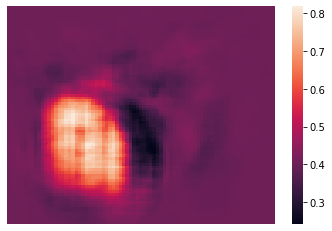

In [ ]:
plot_heatmap(net, trans1(img), 10)